# Tracking test
Perform test for the neuron tracking (identities).  
Inputs are RGB and binary detection frames, and the tracker outputs frames similar to the binary segmentation with a different values for each neuron identity. I.e., 0 is background, 1 is for the pixel of the same neuron through time, 2 is for another neuron, etc.

In [1]:
%matplotlib inline

import os, time, sys
from importlib import reload
import ipywidgets as widgets
from ipywidgets import interact

import numpy as np
from skimage import io, measure
from scipy.spatial.distance import cdist
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn import cluster, mixture

from utils_common.image import to_npint, imread_to_float

%load_ext autoreload
%autoreload 2

In [2]:
id_cmap = matplotlib.cm.get_cmap('viridis')
id_cmap.set_under([0,0,0])

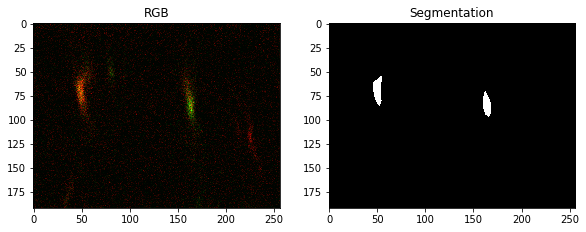

In [12]:
exp = "/data/talabot/pdm/dataset/train/A1_S47-2_fly1_S47_tdTom-GC6s_006/"

rgb_stack = imread_to_float(os.path.join(exp, "RGB.tif"))
seg_stack = io.imread(os.path.join(exp, "seg_ROI.tif")).astype(np.bool)
if os.path.isfile(os.path.join(exp, "lbl_ROI.tif")):
    lbl_stack = io.imread(os.path.join(exp, "lbl_ROI.tif"))
else:
    lbl_stack = None

# Display first frame for visualization
reload(plt)
%matplotlib inline
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.title("RGB")
plt.imshow(rgb_stack[0])
plt.subplot(132)
plt.title("Segmentation")
plt.imshow(seg_stack[0], cmap="gray")
if lbl_stack is not None:
    plt.subplot(133)
    plt.title("Labels")
    plt.imshow(lbl_stack[0], cmap=id_cmap, vmin=1)
plt.show()

## First tracker
Simply tracker working on consecutive pair of frames.
  1. Link closest neurons
  2. If missing neuron in new frame: do nothing
  3. If supplementary neuron in new frame: do nothing / add new ID

### Clustering tracker
Cluster neurons of each frames into a feature space, and regroup them there.

In [15]:
identities = np.zeros(seg_stack.shape, dtype=np.int16)
unique_id = -1 # counter to attribute unique ids to each datapoint (0 is for background)
datapoints = []
true_labels = []
for i in range(seg_stack.shape[0]):
    labels, num = measure.label(seg_stack[i], connectivity=1, return_num=True)
    regions = measure.regionprops(labels)
    
    centroids = np.array([region.centroid for region in regions])
    coord_CoM = centroids.mean(0)
    
    for j in range(num):
        # Attribute unique_id to the datapoint (i.e., for a neuron in a frame)
        identities[i][labels == (j + 1)] = unique_id
        unique_id -= 1
        
        features = np.array([])
        
        # First and second features are row and col coordinates w.r.t. CoM
        features = np.append(features, np.array(regions[j].centroid) - coord_CoM)
        
        # Third feature is area (TODO: see if change to mean width)
        features = np.append(features, regions[j].area)
        
        # If true IDs are known, keep them
        if lbl_stack is not None:
            row, col = regions[j].coords[0]
            true_labels.append(lbl_stack[i, row, col])
        
        datapoints.append(features)
X = np.array(datapoints)
if lbl_stack is not None:
    Y = np.array(true_labels)

# Optional normalization
X = (X - X.mean(0)) / X.std(0)
# X[:,2] *= 0

Number of clusters set to 2


<IPython.core.display.Javascript object>


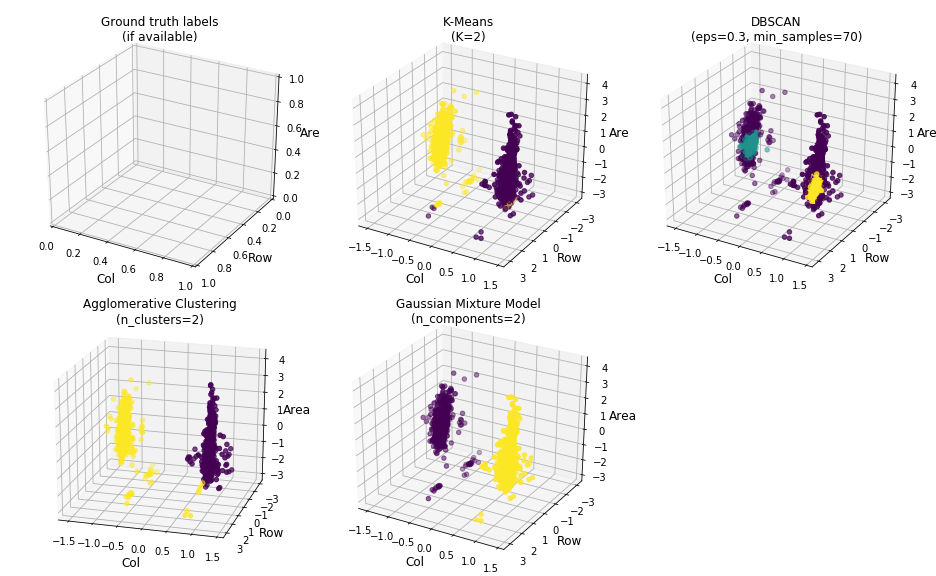

In [16]:
_, num = measure.label(seg_stack[0], return_num=True)
n_clusters = num
print("Number of clusters set to", n_clusters)

reload(plt)
%matplotlib notebook
%matplotlib notebook

plt.figure("Clustering of neuron features", figsize=(13,8))
ax = plt.subplot(231, projection='3d')
plt.title("Ground truth labels\n(if available)")
if lbl_stack is not None:
    ax.scatter(X[:,1], X[:,0], X[:,2], c=Y)
plt.xlabel("Col", fontsize=12); plt.ylabel("Row", fontsize=12); ax.set_zlabel("Area", fontsize=12)
ax.invert_yaxis() # consistent with col dimension of images

K = n_clusters
y_kmeans = cluster.k_means(X, K)[1] + 1

ax = plt.subplot(232, projection='3d')
plt.title("K-Means\n(K=%d)" % K)
ax.scatter(X[:,1], X[:,0], X[:,2], c=y_kmeans)
plt.xlabel("Row"); plt.ylabel("Col"); ax.set_zlabel("Area")
plt.xlabel("Col", fontsize=12); plt.ylabel("Row", fontsize=12); ax.set_zlabel("Area", fontsize=12)
ax.invert_yaxis() # consistent with col dimension of images

eps = 0.3; min_samples = seg_stack.shape[0] // 10
y_dbscan = cluster.dbscan(X, eps, min_samples)[1] + 1

ax = plt.subplot(233, projection='3d')
plt.title("DBSCAN\n(eps=%.1f, min_samples=%d)" % (eps, min_samples))
ax.scatter(X[:,1], X[:,0], X[:,2], c=y_dbscan)
plt.xlabel("Col", fontsize=12); plt.ylabel("Row", fontsize=12); ax.set_zlabel("Area", fontsize=12)
ax.invert_yaxis() # consistent with col dimension of images

n_clusters = n_clusters
agglo_clustering = cluster.AgglomerativeClustering(n_clusters=n_clusters)
y_agglo = agglo_clustering.fit_predict(X) + 1

ax = plt.subplot(234, projection='3d')
plt.title("Agglomerative Clustering\n(n_clusters=%d)" % (n_clusters))
ax.scatter(X[:,1], X[:,0], X[:,2], c=y_agglo)
plt.xlabel("Col", fontsize=12); plt.ylabel("Row", fontsize=12); ax.set_zlabel("Area", fontsize=12)
ax.invert_yaxis() # consistent with col dimension of images

n_components = n_clusters
gmm = mixture.GaussianMixture(n_components=n_components)
y_gmm = gmm.fit_predict(X) + 1

ax = plt.subplot(235, projection='3d')
plt.title("Gaussian Mixture Model\n(n_components=%d)" % (n_components))
ax.scatter(X[:,1], X[:,0], X[:,2], c=y_gmm)
plt.xlabel("Col", fontsize=12); plt.ylabel("Row", fontsize=12); ax.set_zlabel("Area", fontsize=12)
ax.invert_yaxis() # consistent with col dimension of images
plt.tight_layout()
plt.show()

In [17]:
# Assign identities based on unique ids and clustering
y_pred = y_agglo

for i in range(X.shape[0]):
    id = - (i + 1)
    identities[identities == id] = y_pred[i]
identities = identities.astype(np.uint8)

### Visualization

In [18]:
reload(plt)
%matplotlib inline

@interact(image = (0, len(identities) - 1))
def plot_data(image=0):
    plt.figure(figsize=(14,5))
    plt.subplot(131)
    plt.title("Raw input")
    plt.imshow(rgb_stack[image])
    plt.subplot(132)
    plt.title("Binary detection")
    plt.imshow(seg_stack[image], cmap='gray')
    plt.subplot(133)
    plt.title("Identities")
    plt.imshow(identities[image], cmap=id_cmap, vmin=1, vmax=identities.max())
    plt.show()

interactive(children=(IntSlider(value=0, description='image', max=699), Output()), _dom_classes=('widget-inter…

2


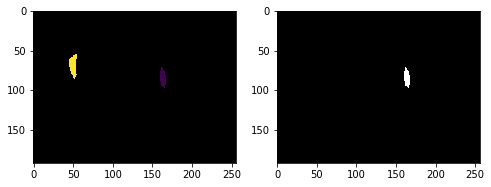

In [19]:
n = 0
print(identities.max())
reload(plt)
%matplotlib inline
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(identities[n], cmap=id_cmap, vmin=1, vmax=identities.max())
plt.subplot(122)
plt.imshow(identities[n] == 1, cmap="gray")
plt.show()

## Fluorescence extraction
Extract tdTomato and GCaMP fluorescence traces for each neurons.

Computing traces took 14.570 s.


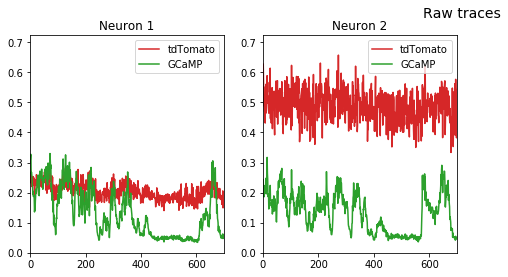

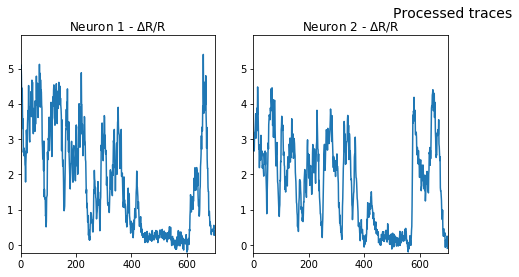

In [20]:
n_frames_0 = 10 # number of frames for the R_0 and F_0 computation

# If too many identities, do not compute traces (modify here to force computation)
if identities.max() >= 10:
    print(identities.max(), "different neurons identified, traces are not computed.")
    sys.exit()

# Mean noise intensity in background
bkg_r = np.mean(rgb_stack[...,0][np.logical_not(seg_stack)])
# bkg_g = np.mean(rgb_stack[...,1][np.logical_not(seg_stack)])
    
traces = np.ones((identities.max(), len(identities), 2)) * np.nan
dR_R = np.zeros((identities.max(), len(identities)))
has_tdTom = np.array([True] * identities.max())

start = time.time()
for i in range(len(identities)):
    for j in range(identities.max()):
        roi = rgb_stack[i,...][identities[i] == j + 1]
        if roi.size > 0:
            traces[j, i, :] = roi.mean(0)[:2]
print("Computing traces took %.3f s." % (time.time() - start))

for i in range(identities.max()):
    # Check if tdTomato is present in the neuron by comparing the mean trace to bkg noise
    if np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]) >= 1.1 * bkg_r:
        R_t = traces[i,...,1] / traces[i,...,0]
    else: # no tdTomato, compute F instead of R
        R_t = traces[i,...,1]
        has_tdTom[i] = False
        print("Neuron {} has no tdTomato (mean < 1.1 * bkg: {:.3f} < {:.3f}). "
              "Fluorescence computed as dF/F.".format(
            i + 1, np.mean(traces[i, np.logical_not(np.isnan(traces[i,...,0])), 0]), 1.1 * bkg_r))
    R_0 = np.convolve(R_t, np.ones(n_frames_0) / n_frames_0, 'valid')
    R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    # If no window of n_frames_0 exists, search for smaller ones
    for j in range(1, n_frames_0):
        if not np.isinf(R_0):
            break
        R_0 = np.convolve(R_t, np.ones(n_frames_0 - j) / (n_frames_0 - j), 'valid')
        R_0 = np.min(np.where(np.isnan(R_0), np.inf, R_0)) # Does not consider np.nan
    dR_R[i] = (R_t - R_0) / R_0

reload(plt)
%matplotlib inline
N = np.ceil(identities.max() / 4)
plt.figure(figsize=(16, 4*N))
plt.suptitle("Raw traces", fontsize=14)
ymax = 1.1 * np.where(np.isnan(traces) + np.isinf(traces), 0, traces).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d" % (i+1))
    plt.plot(traces[i,...,0], color="C3")
    plt.plot(traces[i,...,1], color="C2")
    plt.xlim(0, len(identities))
    plt.ylim(0, ymax)
    plt.legend(["tdTomato", "GCaMP"])
plt.show()
plt.figure(figsize=(16, 4*N))
plt.suptitle("Processed traces", fontsize=14)
if (has_tdTom == True).any():
    ymin_R = min(0, 1.1 * np.nan_to_num(dR_R[has_tdTom]).min())
    ymax_R = 1.1 * np.where(np.isnan(dR_R[has_tdTom]) + np.isinf(dR_R[has_tdTom]), 0, dR_R[has_tdTom]).max()
if (has_tdTom == False).any():
    ymin_F = min(0, 1.1 * np.nan_to_num(dR_R[np.logical_not(has_tdTom)]).min())
    ymax_F = 1.1 * np.where(np.isnan(dR_R[np.logical_not(has_tdTom)]) + np.isinf(dR_R[np.logical_not(has_tdTom)]),
                            0, dR_R[np.logical_not(has_tdTom)]).max()
for i in range(identities.max()):
    plt.subplot(N, 4, i+1)
    plt.title("Neuron %d - " % (i+1) + ("$\Delta$R/R" if has_tdTom[i] else "$\Delta$F/F"))
    plt.plot(dR_R[i], color="C0" if has_tdTom[i] else "C1")
    plt.xlim(0, len(identities))
    plt.ylim(ymin_R if has_tdTom[i] else ymin_F, ymax_R if has_tdTom[i] else ymax_F)
plt.show()